In [ ]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time

from PIL import Image
from keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Input,Dropout
from keras.models import Model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam 




Using TensorFlow backend.


/content/drive/My Drive/DeepLearning-Krish/Number plate


In [ ]:
for dirname , _ , filenames in os.walk('/content/drive/My Drive/DeepLearning-Krish/Number plate'):
  for filename in filenames:
    print(os.path.join(dirname,filename))

/content/drive/My Drive/DeepLearning-Krish/Number plate/Indian_Number_plates.json


In [ ]:
df = pd.read_json("/content/drive/My Drive/DeepLearning-Krish/Number plate/Indian_Number_plates.json",lines=True)

In [ ]:
df.head(5)

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [ ]:
os.mkdir("Indian Number Plates")

In [ ]:
dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()

counter = 0
for index, row in df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save("Indian Number Plates/licensed_car{}.jpeg".format(counter), "JPEG")
    
    dataset["image_name"].append("licensed_car{}".format(counter))
    
    data = row["annotation"]
    
    dataset["image_width"].append(data[0]["imageWidth"])
    dataset["image_height"].append(data[0]["imageHeight"])
    dataset["top_x"].append(data[0]["points"][0]["x"])
    dataset["top_y"].append(data[0]["points"][0]["y"])
    dataset["bottom_x"].append(data[0]["points"][1]["x"])
    dataset["bottom_y"].append(data[0]["points"][1]["y"])
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [ ]:
df = pd.DataFrame(dataset)
df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4,1001,563,0.208791,0.390764,0.865135,0.984014


In [ ]:
cd drive/

'/content'

In [ ]:
df.to_csv("Number_plate.csv",index=False)

In [ ]:
df = pd.read_csv("Number_plate.csv")
df['image_name'] = df['image_name'] + ".jpeg"
df.head(5)

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,1001,563,0.208791,0.390764,0.865135,0.984014


In [ ]:
df.drop(["image_width", "image_height"], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


In [ ]:
#drop random 5-6 model
random_drop = np.random.randint(0,len(df),5)

new_df = df.drop(random_drop,axis=0)


In [ ]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread("Indian Number Plates/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 255, 255), 3)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

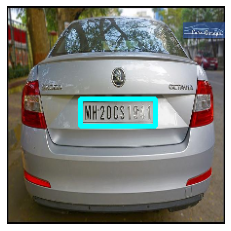

In [ ]:
show_img(12)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    new_df,
    directory="Indian Number Plates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="raw",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    new_df,
    directory="Indian Number Plates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="raw",
    subset="validation")

Found 209 validated image filenames.
Found 23 validated image filenames.


In [ ]:
from keras.applications.vgg16 import VGG16
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
No

## To find the minimum amount of step count to cover all the batches, the following equations are necessary. Mathematically;

- Step size=⌈Number of elements/Batch Size⌉

In [ ]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

In [ ]:
print(STEP_SIZE_TRAIN)

7


In [ ]:
print(STEP_SIZE_VAL)

1


In [ ]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss="mse")

In [ ]:
trainig_model = model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)

Epoch 1/30
7/7 [==============================] - 130s 19s/step - loss: 0.0560 - val_loss: 0.0302
Epoch 2/30
7/7 [==============================] - 1s 153ms/step - loss: 0.0193 - val_loss: 0.0237
Epoch 3/30
7/7 [==============================] - 2s 265ms/step - loss: 0.0133 - val_loss: 0.0193
Epoch 4/30
7/7 [==============================] - 2s 258ms/step - loss: 0.0083 - val_loss: 0.0173
Epoch 5/30
7/7 [==============================] - 2s 262ms/step - loss: 0.0050 - val_loss: 0.0158
Epoch 6/30
7/7 [==============================] - 2s 266ms/step - loss: 0.0032 - val_loss: 0.0153
Epoch 7/30
7/7 [==============================] - 2s 258ms/step - loss: 0.0022 - val_loss: 0.0137
Epoch 8/30
7/7 [==============================] - 2s 260ms/step - loss: 0.0017 - val_loss: 0.0140
Epoch 9/30
7/7 [==============================] - 2s 261ms/step - loss: 0.0011 - val_loss: 0.0136
Epoch 10/30
7/7 [==============================] - 2s 268ms/step - loss: 8.7334e-04 - val_loss: 0.0129
Epoch 11/30
7/7

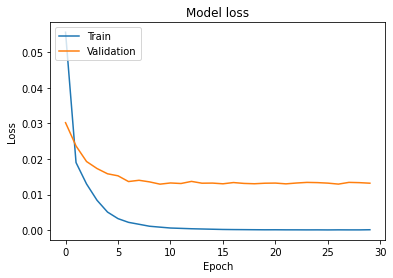

In [ ]:
plt.plot(trainig_model.history['loss'])
plt.plot(trainig_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate_generator(validation_generator, steps=STEP_SIZE_VAL)

0.013202653266489506